_____

In [2]:
import os
import sys
sys.path.append("../utils/")
sys.path.append("../models/")
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch

from models import UNet
from nn_utils import iterate_minibatches
from mulptiprocessing_utils import par_iterate_minibatches
from pytorch_utils import to_numpy, to_var, loss_cross_entropy
from data_utils import load_files, random_nonzero_crops, augment
from data_utils import combine, divide
from metrics import hausdorff, dice

%matplotlib inline

In [3]:
PATH = '/home/mount/neuro-x01-ssd/MICCAI_WMHS/Utr/Utrecht/'
PATH1 = '/home/mount/neuro-x01-ssd/MICCAI_WMHS/Sing/Singapore/' #(232, 256, 48) -> (256, 232, 48),
PATH2 = '/home/mount/neuro-x01-ssd/MICCAI_WMHS/Amst/GE3T/'

In [4]:
masks, t1, flairs = load_files(PATH)
brains = np.concatenate([flairs, t1], axis=1).astype(np.float32)

masks1, t11, flairs1 = load_files(PATH1)
brains1 = np.concatenate([flairs1, t11], axis=1).astype(np.float32)

masks2, t12, flairs2 = load_files(PATH2)
brains2 = np.concatenate([flairs2, t12], axis=1).astype(np.float32)

100%|██████████| 20/20 [00:05<00:00,  3.52it/s]


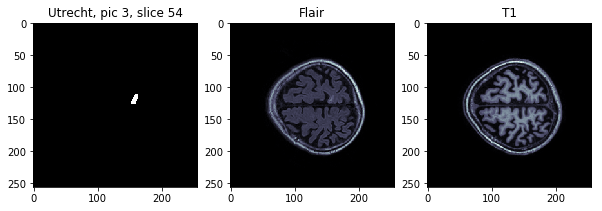

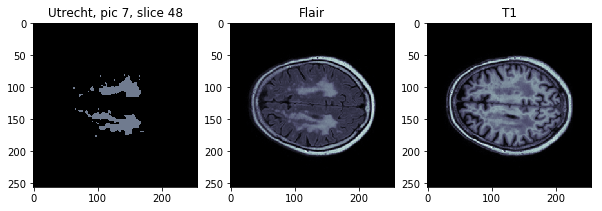

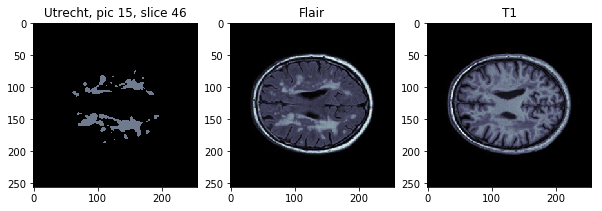

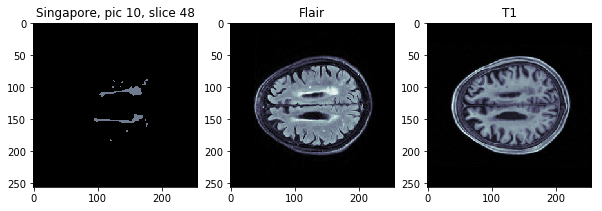

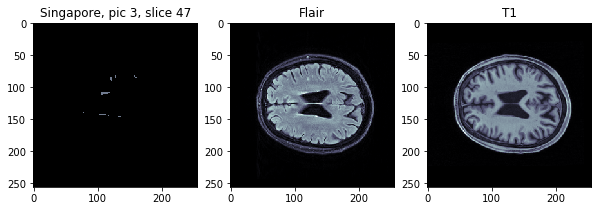

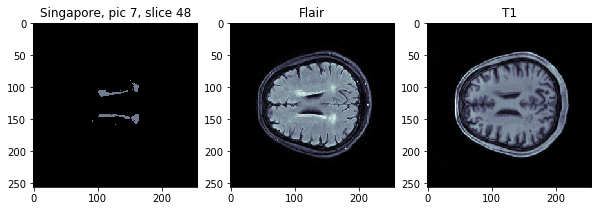

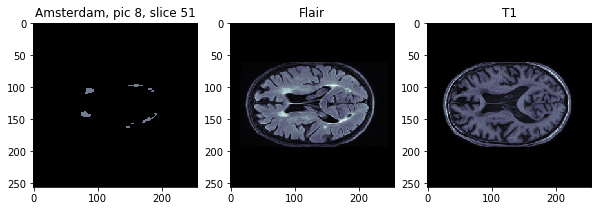

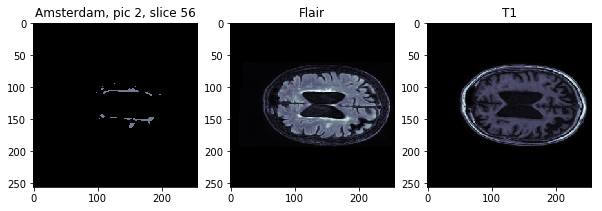

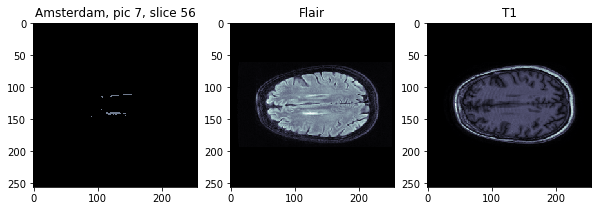

In [5]:
# Visualize

for pic in np.random.choice(range(len(masks)), 3, False):
    plt.figure(figsize=(10,10))
    mask = masks[pic, 0]
    flair = brains[pic, 0]
    tttt = brains[pic, 1]
    t = np.argmax(np.sum(mask[...], axis=(-2, -3)))
    
    plt.subplot(1,3,1)
    plt.title('Utrecht, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,3,2)
    plt.title('Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,3,3)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

for pic in np.random.choice(range(len(masks1)), 3, False):
    plt.figure(figsize=(10,10))
    mask = masks1[pic, 0]
    flair = brains1[pic, 0]
    tttt = brains1[pic, 1]
    t = np.argmax(np.sum(mask[...], axis=(-2, -3)))
    
    plt.subplot(1,3,1)
    plt.title('Singapore, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,3,2)
    plt.title('Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,3,3)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

for pic in np.random.choice(range(len(masks2)), 3, False):
    plt.figure(figsize=(10,10))
    mask = masks2[pic, 0]
    flair = brains2[pic, 0]
    tttt = brains2[pic, 1]
    t = np.argmax(np.sum(mask[...], axis=(-2, -3)))
    
    plt.subplot(1,3,1)
    plt.title('Amsterdam, pic '+ str(pic)+', slice ' + str(t))
    plt.imshow(mask[:, :, t], cmap=plt.cm.bone, vmax=2)
    plt.subplot(1,3,2)
    plt.title('Flair')
    plt.imshow(flair[:, :, t], cmap=plt.cm.bone)
    plt.subplot(1,3,3)
    plt.title('T1')
    plt.imshow(tttt[:, :, t], cmap=plt.cm.bone)

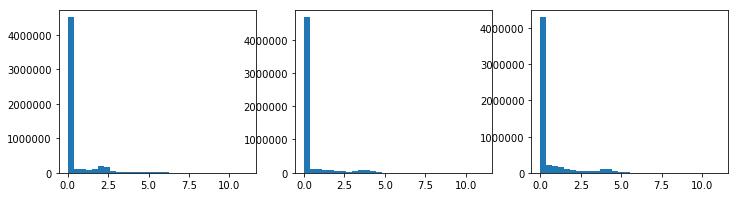

In [6]:
plt.figure(figsize=(12,3))
plt.title('hist of flairs');
plt.subplot(131)
a = plt.hist(brains[8, 0].flatten(), bins=30);
plt.subplot(132)
plt.hist(brains1[8, 0].flatten(), bins=a[1]);
plt.subplot(133)
plt.hist(brains2[8, 0].flatten(), bins=a[1]);

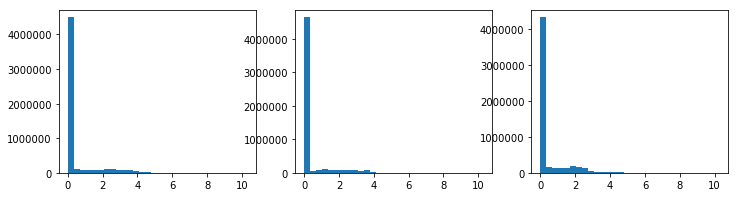

In [7]:
plt.figure(figsize=(12,3))
plt.title('hist of t1')
plt.subplot(131)
a = plt.hist(brains[8, 1].flatten(), bins=30);
plt.subplot(132)
plt.hist(brains1[8, 1].flatten(), bins=a[1]);
plt.subplot(133)
plt.hist(brains2[8, 1].flatten(), bins=a[1]);

____

In [8]:
def get_train_split(get_train_split=20, n=15):
    return np.in1d(np.array(range(get_train_split)), 
                   np.random.choice(range(get_train_split), n, False))

In [9]:
idx1, idx2, idx3 = get_train_split(), get_train_split(), get_train_split()
idx1, idx2, idx3

(array([False, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True, False,  True, False,  True,  True,  True,  True,
        False,  True], dtype=bool),
 array([ True,  True, False, False,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True, False,
         True, False], dtype=bool),
 array([ True, False,  True, False,  True,  True,  True,  True,  True,
         True,  True,  True, False,  True,  True, False,  True,  True,
         True, False], dtype=bool))

In [10]:
#train_test_split
X_train = np.concatenate([brains[idx1], brains1[idx2], brains2[idx3]])
X_test = np.concatenate([brains[~idx1], brains1[~idx2], brains2[~idx3]])
Y_train = np.concatenate([masks[idx1], masks1[idx2], masks2[idx3]])
Y_test = np.concatenate([masks[~idx1], masks1[~idx2], masks2[~idx3]])

X_train = np.concatenate([brains[idx1]])
X_test = np.concatenate([brains[~idx1]])
Y_train = np.concatenate([masks[idx1]])
Y_test = np.concatenate([masks[~idx1]])

In [11]:
X_train.shape, X_test.shape

((45, 2, 256, 256, 84), (15, 2, 256, 256, 84))

In [12]:
del brains, brains1, brains2, masks, masks1, masks2

___

In [13]:
# архитектура которая смотрит больший конектст и предсказывает мелкий
# оптимизировать дайс

model = UNet().cuda()

In [18]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_of_patches = 600
batch_size = 30
epoches = 120

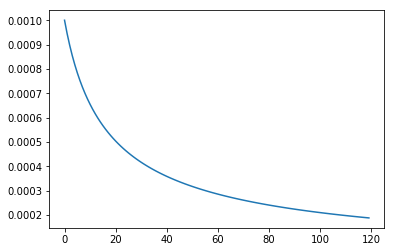

In [19]:
plt.plot([learning_rate / (1 + 10 * epoch / epoches) ** 0.7 for epoch in range(epoches)])

____

In [20]:
lr_arr = []
tr_loss_arr = []
val_loss_arr = []

In [21]:
def train(epoch, prev_inp, prev_targ, hard_neg_mining=True):
    """
    Train procedure.
    """
    
    global optimizer
    global epoches
    
    ep = 'Epoch %d: ' % epoch
    mean_loss, step = 0, 0
    model.train()
    # augm all brains with elastic transformations
    
    inputs, targets = random_nonzero_crops(X_train, Y_train,
                                           num_of_patches, 
                                           shape=(50, 50, 42))
    if hard_neg_mining:
        print ('added', len(prev_inp), 'examples')
        inputs = np.concatenate([inputs, prev_inp])
        targets = np.concatenate([targets, prev_targ])
        
    # augmentation
    bar = tqdm(par_iterate_minibatches(inputs, targets, batch_size, augment, shuffle=False),
              total=inputs.shape[0] // batch_size)
    
#     bar = tqdm(iterate_minibatches(inputs, targets, batch_size, shuffle=False),
#               total=inputs.shape[0] // batch_size)
    
    for x, y_true in bar:
#         tmp = [augment(*i) for i in zip(x, y_true)]
#         x = np.array([t[0] for t in tmp])
#         y_true = np.array([t[1] for t in tmp])
        x = to_var(np.array(x)).cuda()
        y_true = to_var(np.array(y_true)).cuda()
        y_pred = model(x)
        batch_loss = loss_cross_entropy(y_pred, y_true).cpu()
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        del x, y_true, y_pred
        
        mean_loss += batch_loss.data[0]
        step += 1
        bar.set_description(ep + str(batch_loss.data[0])[:6])
    
    if epoch % 10 == 0 and epoch <= 107:
        _ = learning_rate / (1 + 10 * epoch / epoches) ** 0.7
        print ('lr', _)
        optimizer = torch.optim.Adam(model.parameters(), lr=_)
    
    for i in optimizer.param_groups:
        lr_arr.append(i['lr'])
        break
        
    idx = validate(epoch, inputs=inputs, targets=targets, hard_neg_mining=True)
    
    return mean_loss / step, inputs[idx], targets[idx]

In [22]:
def validate(epoch, inputs=None, targets=None, hard_neg_mining=False, part=30):
    """
    part: int,
        number of objects for negative mining.
    """
    ep = 'Epoch %d: ' % epoch
    mean_loss, step = 0, 0
    model.eval()
    if not hard_neg_mining:
        inputs, targets = random_nonzero_crops(X_test, Y_test, 
                                               num_of_patches=120,
                                               shape=(42, 42, 32))
        batch_size_ = batch_size
    else:
        batch_size_ = 1
        hard_neg_idx = []
        
    bar = tqdm(iterate_minibatches(inputs, targets, batch_size_, shuffle=False),
              total=inputs.shape[0] // batch_size)
    
    for x, y_true in bar:
        x = to_var(x, volatile=True).cuda()
        y_true = to_var(y_true, volatile=True).cuda()
        y_pred = model.forward(x)
        
        batch_loss = loss_cross_entropy(y_pred, y_true).cpu()
        
        del x, y_true
        
        mean_loss += batch_loss.data[0]
        if hard_neg_mining:
            hard_neg_idx.append(batch_loss.data[0])
        
        step += 1
        bar.set_description(ep + str(batch_loss.data[0])[:6])
        
    if hard_neg_mining:
        return np.argsort(np.array(hard_neg_idx))[::-1][:part]
    return mean_loss / step

In [23]:
def validate_nuts(epch, visualize = False):
    shape = X_test.shape
    n_parts_per_axis = [1, 1, 4, 4, 2]
    padding = [0, 0, 0, 0, 0]
    zero_padding = [0] * 5
    a_parts = divide(X_test, zero_padding, n_parts_per_axis)
    pred = []
    model.eval()
    for i in a_parts:
        i = to_var(i).cuda()
        pred.append(to_numpy(model(i)))
    a_2 = combine(pred, n_parts_per_axis)
    y_pred = np.logical_and(a_2[:, 1, ...] > a_2[:, 0, ...], 
                            a_2[:, 1, ...] > a_2[:, 2, ...])
    
    if visualize:
        for i in range(len(X_test)):
            t = np.argmax(np.sum(Y_test[i,0, ..., :], axis=(-2, -3)))
            plt.figure()
            plt.subplot(121)
            plt.title('predicted ' + str(dice(y_pred[i], Y_test[i,0]))[:5] )
            plt.imshow(y_pred[i, ..., t], cmap=plt.cm.bone)
            plt.subplot(122)
            plt.title('ground_truth')
            plt.imshow(Y_test[i,0, ..., t], cmap=plt.cm.bone, vmax=2);
            plt.savefig('../reports/figures/3D_UNet/'+str(i)+'.png')
            
        with open('../reports/figures/3D_UNet/README.md', 'w') as f:
            for i in range(len(X_test)):
                f.write('![./figures/3D_UNet/'+str(i)+'.png](./figures/3D_UNet/'+str(i)+'.png)\n')
        
    return ([dice(y_pred[i], Y_test[i,0]) for i in range(len(X_test))], 
            [hausdorff(y_pred[i].astype(int),
                       Y_test[i,0].astype(int), label=1)  
             for i in range(len(X_test))])

_____

In [ ]:
print ('starting train for {} epoches'.format(epoches))
with open('../reports/logs/3dunet_out.txt', 'w') as f:
    f.write('\nBegin at'+str(datetime.now())[:19]+'\n')
        
prev_inp, prev_targ = [], []
for epoch in range(epoches):
    tr_loss, prev_inp, prev_targ = train(epoch, prev_inp, prev_targ, epoch>=1 and epoch%5!=0)
    test_loss = validate(epoch)
    tr_loss_arr.append(tr_loss)
    val_loss_arr.append(test_loss)
    with open('../reports/logs/3dunet_out.txt', 'a') as f:
        f.write('\nEpoch:'+str(epoch))
        f.write('\n  Train logloss '+ str(tr_loss))
        f.write('\n  Test logloss '+ str(test_loss))
        f.close()

starting train for 120 epoches


  0%|          | 0/20 [00:00<?, ?it/s]

lr 0.001


Epoch 0: 0.0334: 612it [00:25, 24.23it/s]                       
Epoch 0: 0.1195: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


added 30 examples


Epoch 1: 0.1244: 100%|██████████| 21/21 [00:45<00:00,  2.16s/it]
Epoch 1: 0.1429: 653it [00:26, 24.23it/s]                       
Epoch 1: 0.0669: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


added 30 examples


Epoch 2: 0.2474: 100%|██████████| 21/21 [00:45<00:00,  2.16s/it]
Epoch 2: 0.1553: 638it [00:26, 24.22it/s]                       
Epoch 2: 0.0502: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


added 30 examples


Epoch 3: 0.3134: 100%|██████████| 21/21 [00:45<00:00,  2.16s/it]
Epoch 3: 0.2051: 630it [00:26, 24.21it/s]                       
Epoch 3: 0.0603: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


added 30 examples


Epoch 4: 0.1797: 100%|██████████| 21/21 [00:45<00:00,  2.16s/it]
Epoch 4: 0.2375: 649it [00:26, 24.56it/s]                       
Epoch 5: 0.0345: 100%|██████████| 20/20 [00:43<00:00,  2.16s/it]
Epoch 5: 0.0243: 605it [00:25, 24.19it/s]                       
Epoch 5: 0.0656: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


added 30 examples


Epoch 6: 0.1966: 100%|██████████| 21/21 [00:45<00:00,  2.15s/it]
Epoch 6: 0.1909: 645it [00:26, 24.23it/s]                       
Epoch 6: 0.0860: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


added 30 examples


Epoch 7: 0.2886: 100%|██████████| 21/21 [00:45<00:00,  2.16s/it]
Epoch 7: 0.2065: 631it [00:26, 24.57it/s]                       
Epoch 7: 0.0442: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


added 30 examples


Epoch 8: 0.2920: 100%|██████████| 21/21 [00:45<00:00,  2.16s/it]
Epoch 8: 0.2169: 633it [00:26, 24.22it/s]                       
Epoch 8: 0.0737: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


added 30 examples


Epoch 9: 0.0353:  71%|███████▏  | 15/21 [00:32<00:12,  2.16s/it]

In [ ]:
plt.plot(lr_arr)

In [ ]:
plt.plot(tr_loss_arr, label='Train')
plt.plot(val_loss_arr, label='val')
plt.legend()

In [ ]:
a = validate_nuts(0, True)
print(a)

_____

In [ ]:
import pickle
with open('../models/dumps/model_unetcnn.pkl', 'wb') as f:
    pickle.dump(model.state_dict(), f, protocol=pickle.HIGHEST_PROTOCOL)

___

___